In [11]:
import pandas as pd
import os
import numpy as np

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

### Which genres receive the highest ratings? How does this change over time?

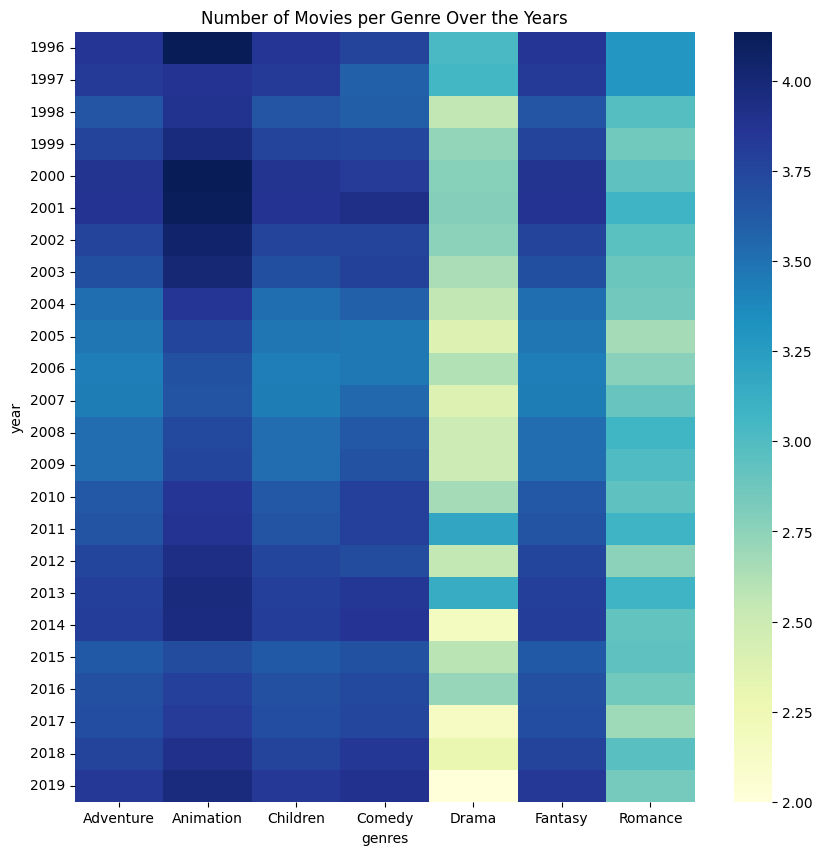

In [15]:
# Load Data
ratings = pd.read_csv("data/ratings.csv")
movies = pd.read_csv("data/movies.csv")

# Merge movies and ratings
data = pd.merge(movies, ratings)[:100000]

# Create a year column
data["year"] = data["timestamp"].apply(lambda x: pd.to_datetime(x, unit="s").year)

# Split genres and explode
data["genres"] = data["genres"].str.split("|")
data = data.explode("genres")

# Calculate average ratings
avg_ratings = data.groupby(["year", "genres"])["rating"].mean().reset_index()

# Pivot the data to have years as index, genres as columns and avg_ratings as values
avg_ratings_pivot = avg_ratings.pivot(index="year", columns="genres", values="rating")

plt.figure(figsize=(10, 10))
sns.heatmap(avg_ratings_pivot.fillna(0), cmap="YlGnBu")
plt.title("Number of Movies per Genre Over the Years")
plt.show()

### 2. Determine the temporal trends in the genres/tagging activity of the movies released.

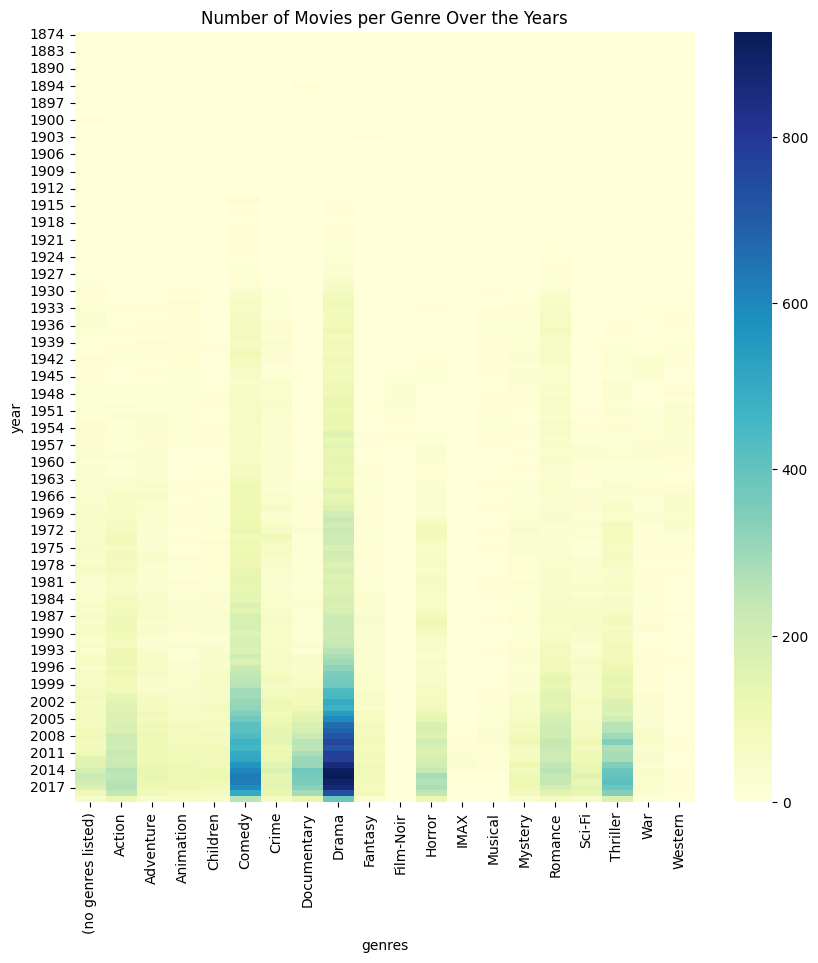

In [14]:
# Load Data
movies = pd.read_csv("data/movies.csv")

# Create a year column from the title
movies["year"] = movies["title"].str.extract("\((\d{4})\)")

# Split genres and explode
movies["genres"] = movies["genres"].str.split("|")
movies = movies.explode("genres")

# Count number of movies per genre each year
genre_counts = movies.groupby(["year", "genres"]).size().reset_index(name="counts")

# Pivot the data to have years as index, genres as columns and counts as values
genre_counts_pivot = genre_counts.pivot(index="year", columns="genres", values="counts")

plt.figure(figsize=(10, 10))
sns.heatmap(genre_counts_pivot.fillna(0), cmap="YlGnBu")
plt.title("Number of Movies per Genre Over the Years")
plt.show()

# SVD

In [21]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# Load Data
ratings = pd.read_csv("data/ratings.csv")  # Assuming the file is ratings.csv
# The columns are 'userId', 'movieId', 'rating', 'timestamp'

# Define the format
reader = Reader(
    rating_scale=(0.5, 5)
)  # Rating scale in movielens dataset is from 0.5 to 5

# Create the dataset to be used for building the filter
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

# Split data into training and test set
trainset, testset = train_test_split(data, test_size=0.25)

# Define the algorithm - SVD (Singular Value Decomposition)
svd = SVD()

svd.fit(trainset)

# Test on the testset
predictions = svd.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.7812


0.7811643508110793

In [22]:
# Save the trained model
from surprise import dump
from surprise import SVD, Dataset, accuracy

file_name = "artifacts/svd_model"
dump.dump(file_name, algo=svd)

In [23]:
from surprise import SVD, Dataset, accuracy

# Now, let's say we want to predict the rating that User with ID 1 would give to the movie with ID 302
user_id = 1
movie_id = 302

_, loaded_algo = dump.load(file_name)

# Make predictions using the loaded model
predictions = loaded_algo.predict(user_id, movie_id)

In [24]:
print(predictions)

user: 1          item: 302        r_ui = None   est = 4.00   {'was_impossible': False}


In [26]:
def recommend_movies(user_id, n_movies_to_recommend, model, movies_df, ratings_df):
    # Get a list of all movie ids
    all_movies = ratings_df["movieId"].unique()

    # Get a list of movies that user has rated
    user_ratings = ratings.loc[ratings["userId"] == user_id, "movieId"]

    # Find movies that the user hasn't rated yet
    movies_to_predict = np.setdiff1d(all_movies, user_ratings)

    # Use SVD to predict the rating for every movie the user hasn't rated yet
    predicted_ratings = np.array(
        [model.predict(user_id, iid).est for iid in movies_to_predict]
    )

    # Find the index of maximum ratings
    top_n_idx = np.argsort(predicted_ratings)[-n_movies_to_recommend:][::-1]

    # Find the ids of top ratings
    top_n_movie_ids = movies_to_predict[top_n_idx]

    # Get movie titles
    top_movies = movies_df.loc[movies_df["movieId"].isin(top_n_movie_ids), "title"]

    return top_movies

In [27]:
print(
    recommend_movies(
        user_id=1,
        n_movies_to_recommend=5,
        model=loaded_algo,
        movies_df=movies,
        ratings_df=ratings,
    )
)

314                       Shawshank Redemption, The (1994)
729                 Wallace & Gromit: A Close Shave (1995)
17822                                Civil War, The (1990)
19761    Ivan Vasilievich: Back to the Future (Ivan Vas...
32968                               The Blue Planet (2001)
Name: title, dtype: object


# Matrix Factorization (MF)

In [42]:
PATH = Path("data/")
list(PATH.iterdir())

[WindowsPath('data/genome-scores.csv'),
 WindowsPath('data/genome-tags.csv'),
 WindowsPath('data/links.csv'),
 WindowsPath('data/movies.csv'),
 WindowsPath('data/ratings.csv'),
 WindowsPath('data/README.txt'),
 WindowsPath('data/tags.csv'),
 WindowsPath('data/train_ratings.csv'),
 WindowsPath('data/val_ratings.csv')]

In [48]:
data = pd.read_csv(PATH / "ratings.csv")[:100000]
data.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [49]:
# load data
ratings = pd.read_csv(PATH / "ratings.csv")

# Make sure user_id and movie_id are continuous
user_enc = LabelEncoder()
ratings["userId"] = user_enc.fit_transform(ratings["userId"].values)
n_users = ratings["userId"].nunique()

item_enc = LabelEncoder()
ratings["movieId"] = item_enc.fit_transform(ratings["movieId"].values)
n_movies = ratings["movieId"].nunique()

# train-val-test split
# Split into train and test
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# Further split train into train and validation
train_ratings, val_ratings = train_test_split(
    train_ratings, test_size=0.2, random_state=42
)


# Convert to PyTorch tensors
train_ratings = torch.tensor(train_ratings.values)
test_ratings = torch.tensor(test_ratings.values)
val_ratings = torch.tensor(val_ratings.values)

In [51]:
train_ratings.shape

torch.Size([64000, 4])

In [26]:
# an Embedding module containing 10 user or item embedding size 3
# embedding will be initialized at random
embed = nn.Embedding(10, 3)

# given a list of ids we can "look up" the embedding corresponing to each id
a = torch.LongTensor([[1, 2, 0, 4, 5, 1]])
embed(a)

tensor([[[-1.8485,  1.1997,  0.5428],
         [-0.9119,  0.7682,  0.1729],
         [ 0.5945,  2.0846,  1.2951],
         [ 1.1736, -1.4331,  1.3092],
         [-0.1485, -0.1210,  0.9168],
         [-1.8485,  1.1997,  0.5428]]], grad_fn=<EmbeddingBackward0>)

In [54]:
class MF_bias(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super(MF_bias, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.item_bias = nn.Embedding(num_items, 1)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)
        self.user_bias.weight.data.uniform_(-0.01, 0.01)
        self.item_bias.weight.data.uniform_(-0.01, 0.01)

    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        b_u = self.user_bias(u).squeeze()
        b_v = self.item_bias(v).squeeze()
        return (U * V).sum(1) + b_u + b_v

In [57]:
# Note here there is no matrix multiplication, we could potentially make the embeddings of different sizes.
# Here we could get better results by keep playing with regularization.


class CollabFNet(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, n_hidden=10):
        super(CollabFNet, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.lin1 = nn.Linear(emb_size * 2, n_hidden)
        self.lin2 = nn.Linear(n_hidden, 1)
        self.drop1 = nn.Dropout(0.1)

    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        x = F.relu(torch.cat([U, V], dim=1))
        x = self.drop1(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [58]:
# Parameters
emb_size = 100
batch_size = 500
epochs = 10
learning_rate = 0.01

# Model
model = CollabFNet(n_users, n_movies, emb_size=emb_size)

# Loss
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Data loader
train_loader = DataLoader(train_ratings, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ratings, batch_size=batch_size)

# Training loop
for epoch in range(epochs):
    model.train()
    for i, batch in enumerate(train_loader):
        # Get input batch
        user = Variable(batch[:, 0]).long()
        item = Variable(batch[:, 1]).long()
        rating = Variable(batch[:, 2]).float()

        # Forward pass
        prediction = model(user, item)
        loss = criterion(prediction, rating)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Eval
    model.eval()
    val_loss = 0
    for i, batch in enumerate(val_loader):
        with torch.no_grad():
            # Get input batch
            user = Variable(batch[:, 0]).long()
            item = Variable(batch[:, 1]).long()
            rating = Variable(batch[:, 2]).float()

            pred = model(user, item)
            loss = criterion(pred, rating)
        val_loss += loss.item()

    val_loss /= len(val_loader)
    # Print progress
    print(f"Epoch {epoch+1}: Train Loss {loss:.3f} | Val Loss {val_loss:.3f}")

print("Training complete!")

c:\Users\alira\anaconda3\envs\recommendation-system\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([500])) that is different to the input size (torch.Size([500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: Train Loss 1.147 | Val Loss 1.094
Epoch 2: Train Loss 1.146 | Val Loss 1.091
Epoch 3: Train Loss 1.139 | Val Loss 1.088
Epoch 4: Train Loss 1.144 | Val Loss 1.090
Epoch 5: Train Loss 1.147 | Val Loss 1.091
Epoch 6: Train Loss 1.139 | Val Loss 1.088
Epoch 7: Train Loss 1.179 | Val Loss 1.116
Epoch 8: Train Loss 1.137 | Val Loss 1.087
Epoch 9: Train Loss 1.148 | Val Loss 1.092
Epoch 10: Train Loss 1.154 | Val Loss 1.097
Training complete!
